# Solve elastic equation on a square
This is a simple example to solve the elastic equations on a square geometry.

In [1]:
import skfem as fem
from skfem.visuals.matplotlib import plot
from skfem.helpers import ddot, trace, sym_grad, eye, dot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
line_load = 0.1
gravity = [0.0, 0.1]

mu = 1.0
lmb = 1.0

def C(T):
    """Linear-elastic stress-strain relationship."""
    return 2. * mu * T + lmb * eye(trace(T), T.shape[0])

In [3]:
@fem.BilinearForm
def momentum_flux(u, v, _):
    return ddot(C(sym_grad(u)), sym_grad(v))

In [4]:
@fem.LinearForm
def body_force(v, w):
    return dot(gravity, v)

In [5]:
@fem.LinearForm
def loading(v, w):
    return dot(w.n, v)

In [6]:
mesh = fem.MeshQuad().refined(3)

In [7]:
e1 = fem.ElementQuad1()
mapping = fem.MappingIsoparametric(mesh, e1)
e = fem.ElementVector(e1)
basis = fem.Basis(mesh, e, mapping)
load_basis = fem.FacetBasis(mesh, e, facets=mesh.boundaries["top"])

In [8]:
K = fem.asm(momentum_flux, basis)
B = fem.asm(body_force, basis) + line_load * fem.asm(loading, load_basis)

In [9]:
dofs = {
    'left' : basis.get_dofs(lambda x: x[0] == 0.0),
    'right': basis.get_dofs(lambda x: x[0] == 1.0),
}
u = basis.zeros()
u[dofs['right'].nodal['u^1']] = 0.3

I = basis.complement_dofs(dofs)

In [10]:
u = fem.solve(*fem.condense(K, B, x=u, I=I))
u1 = u[basis.nodal_dofs[0]]
u2 = u[basis.nodal_dofs[1]]

In [11]:
sgb = basis.with_element(fem.ElementVector(e))
ui = basis.interpolate(u)
sigma = sgb.project(C(sym_grad(ui)))
# sigma[sgb.nodal_dofs[3]]

<AxesSubplot:>

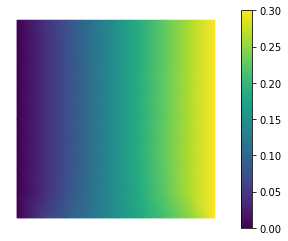

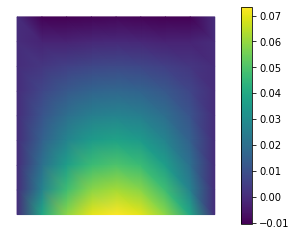

In [12]:
plot(mesh, u1, shading='gouraud', colorbar=True)
plot(mesh, u2, shading='gouraud', colorbar=True)